# Analiza czynników mogących wpływać na prawdopodobieństwo powrotu użytkownika na stronę

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
%matplotlib inline

Załadowanie zbioru danych i oczyszczenie z niepotrzebnych znaków

In [2]:
file = "dane.csv"
df = pd.read_csv(file, header=0, sep="[;]", engine="python", 
                 names=("client_id","action_time", "pagePath", "medium", "eventAction", "date"))
df.client_id = df.client_id.str[1:]
df.date = df.date.str[:-1]
df.head()

,client_id,action_time,pagePath,medium,eventAction,date
0,d0a213b0718cd0e10475ce11d893c3cc,2020-07-29T15:38:27Z,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",organic,pageview,29.07.2020
1,4416f6ec763cc9e65ca17482d3960971,2020-07-29T21:03:06Z,/,(none),pageview,29.07.2020
2,c3d6e02ad3e2a781dba7c48a4d354199,2020-07-29T07:51:28Z,/o-portalu,banner,pageview,29.07.2020
3,3bd4feb129163c7889a70d3d12c6e82d,2020-07-29T12:23:00Z,"/lekcja/geografia,12901cca29551ad7d556962231a1...",organic,pageview,29.07.2020
4,3d90c06c313a2120ce98ff14b6581570,2020-07-29T12:27:30Z,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",organic,pageview,29.07.2020


Opis zmiennych:
   - client_id - ID użytkownika (pozyskiwane za pomocą cookie)
   - ts - dokładny czas, w którym nastąpiło wydarzenie
   - pagePath - ścieżka strony, która była oglądana
   - medium - czyli medium, z którego użytkownik przyszedł na stronę
   - eventAction - rodzaj akcji wykonanej przez użytkownika
   - date - data zdarzenia<br />&nbsp;&nbsp;&nbsp;

Opis mediów kolumny "medium":
   - cpc - wejście z kampanii marketingowej
   - organic - wejście z wyszukiwarki
   - banner - wejście z baneru reklamowego
   - referral - wejście z linku polecającego
   - email - wejście przez mail
   - post - wejście przez post
   - link - wejście przez link
   - webpush - wejście przez wiadomości, wysyłane przez stronę internetową

Konwersja kolumny "date" na *datetime* i utworzenie kolumny "time" z czasem zdarzenia

In [3]:
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
df["action_time"] = pd.to_datetime(df["action_time"]).dt.time

In [4]:
print(df.isnull().values.sum())

0


 Dane nie zawierają wartości pustych, nie wymagają więc oczyszczenia z nich.


In [5]:
df["medium"] = df["medium"].astype("category")

Zmiana typu danych kolumny "medium" na typ danych *category*

In [6]:
df.describe()

,client_id,action_time,pagePath,medium,eventAction,date
count,466822,466822,466822,466822,466822,466822
unique,230193,70553,2549,10,1,37
top,64e4c7ca28927cfd62a503e100afe752,10:08:41,/,organic,pageview,2020-08-21 00:00:00
freq,855,26,67224,260306,466822,25938
first,NaN,NaN,NaN,NaN,NaN,2020-07-29 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2020-10-09 00:00:00


In [7]:
df.drop(["eventAction"], axis="columns", inplace=True)

Kolumna "eventAction" zostaje usunięta z powodu występowania tylko jednej zmiennej.

Podliczenie wystąpień każdego z mediów, z którego użytkownik mógł wejść na stronę.

In [8]:
df["medium"].value_counts()

organic      260306
(none)        67090
cpc           50864
banner        46942
referral      30169
email         11243
post            102
link             74
webpush          31
(not set)         1
Name: medium, dtype: int64

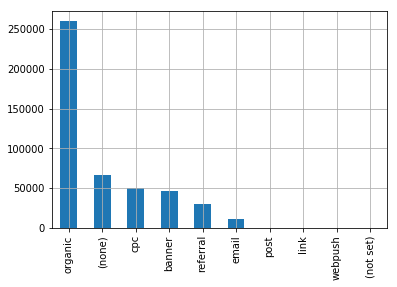

In [9]:
df["medium"].value_counts().plot(kind="bar", grid=True)

W zbiorze istnieją dwie pozycje nieprzypisane do żadnego z mediów: (none) i (not set).

In [10]:
df.loc[df["medium"] == "(none)", "medium"] = "(not set)"

In [11]:
df["pagePath"].head(20)

0     /lekcja/biologia,75f95eb9a371db8c2ea854da85219502
1                                                     /
2                                            /o-portalu
3     /lekcja/geografia,12901cca29551ad7d556962231a1...
4     /lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...
5     /lekcja/jezyk-polski,8a99b0c8047266b628e7a7d3b...
6                                                     /
7                                                     /
8                                                     /
9                                            /o-portalu
10                                                    /
11                                                    /
12    /lekcja/jezyk-polski,9c53c1abcacdf5cf9553c8388...
13                                                    /
14                                    /?standalone=true
15    /lekcja/historia,6d6334ff96cc0d0d429537dbc3c69366
16    /lekcja/historia,6d6334ff96cc0d0d429537dbc3c69366
17                                              

Stworzenie kolumny "pageMainCat" z kategoriami występującymi w kolumnie "pagePath". Ścieżki nie przypisane do żadnej z kategorii, otrzymują etykietę "Others"

In [12]:
df["pageMainCat"] = df["pagePath"]

In [13]:
main_categories = {
    "/lekcja/": "lekcja", 
    "/kategorie/": "kategorie",
    "/fiszki-i-quizy/": "fiszki-i-quizy",
    "/sprawdz-sie/": "sprawdz-sie",    
    "/quiz/": "quiz",
    "/fiszki/": "fiszki",
    "/szukaj/": "szukaj",
    "lesson/preview": "lesson/preview",
    "/o-portalu": "o-portalu",
}
    
for key, value in main_categories.items():
    df["pageMainCat"] = df["pageMainCat"].astype(str).apply(lambda x:  value if key in x else x) 
    
cat_set = set(main_categories.values())
df["pageMainCat"] = df["pageMainCat"].apply(lambda x: x if x in cat_set else "Others")  

In [14]:
df["pageMainCat"] = df["pageMainCat"].astype("category")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466822 entries, 0 to 466821
Data columns (total 6 columns):
client_id      466822 non-null object
action_time    466822 non-null object
pagePath       466822 non-null object
medium         466822 non-null category
date           466822 non-null datetime64[ns]
pageMainCat    466822 non-null category
dtypes: category(2), datetime64[ns](1), object(3)
memory usage: 15.1+ MB


Ilustracja częstości występowania danej głównej kategorii z kolumny "pageMainCat" w ujęciu logarytmicznym.

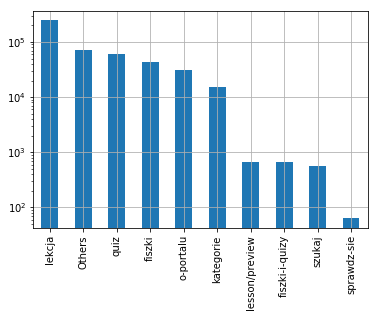

In [48]:
df["pageMainCat"].value_counts().plot(kind="bar", logy=True, grid=True)

Kodowanie kolumny "medium", gdzie "organic" przyjmuje wartość jeden, a pozostałe rodzje przyjmują wartość zero.

In [17]:
df_specific = df.copy()
df_specific["Organic_code"] = np.where(df_specific["medium"].str.contains("organic"), 1, 0)
df_specific = df_specific.drop("medium", axis = 1)

df_specific.head()

,client_id,action_time,pagePath,date,pageMainCat,Organic_code
0,d0a213b0718cd0e10475ce11d893c3cc,15:38:27,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",2020-07-29,lekcja,1
1,4416f6ec763cc9e65ca17482d3960971,21:03:06,/,2020-07-29,Others,0
2,c3d6e02ad3e2a781dba7c48a4d354199,07:51:28,/o-portalu,2020-07-29,o-portalu,0
3,3bd4feb129163c7889a70d3d12c6e82d,12:23:00,"/lekcja/geografia,12901cca29551ad7d556962231a1...",2020-07-29,lekcja,1
4,3d90c06c313a2120ce98ff14b6581570,12:27:30,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",2020-07-29,lekcja,1


Kodowanie zmiennych "pageMainCat" za pomocą metody *Target/Guided Encoding*.

Obliczenie prawdopodobieństwa każdej z głównych kategorii na podstawie wartości celu kolumny "Organic_code".

In [18]:
df_specific.groupby(["pageMainCat"])["Organic_code"].mean()

pageMainCat
Others            0.140407
fiszki            0.285261
fiszki-i-quizy    0.758673
kategorie         0.371252
lekcja            0.858868
lesson/preview    0.239291
o-portalu         0.002661
quiz              0.351063
sprawdz-sie       0.640625
szukaj            0.307554
Name: Organic_code, dtype: float64

Największe prawdopodobieństwo, że użytkownik wchodzący na stronę przez wyszukiwarkę (organic) występuje dla lekcji - ok. 86%.

In [19]:
Encoded_Lables = df_specific.groupby(["pageMainCat"])["Organic_code"].mean().sort_values().index

Stworzenie słowników zawierających klucz jako nazwę głównej kategorii i wartościami jako wspólny ranking prawdopodobieństwa.

In [20]:
Encoded_Lables_Ranks = { k:i for i, k in enumerate(Encoded_Lables, 0) }

Stworzenie nowej kolumny "pageMainCat_Encoded" i zmapowanie wartośći głównych kategorii z rankingiem wspólnego prawdopodobieństwa.

In [21]:
df_specific["pageMainCat_Encoded"] = df_specific["pageMainCat"].map(Encoded_Lables_Ranks)

In [22]:
df_specific.head()

,client_id,action_time,pagePath,date,pageMainCat,Organic_code,pageMainCat_Encoded
0,d0a213b0718cd0e10475ce11d893c3cc,15:38:27,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",2020-07-29,lekcja,1,9
1,4416f6ec763cc9e65ca17482d3960971,21:03:06,/,2020-07-29,Others,0,1
2,c3d6e02ad3e2a781dba7c48a4d354199,07:51:28,/o-portalu,2020-07-29,o-portalu,0,0
3,3bd4feb129163c7889a70d3d12c6e82d,12:23:00,"/lekcja/geografia,12901cca29551ad7d556962231a1...",2020-07-29,lekcja,1,9
4,3d90c06c313a2120ce98ff14b6581570,12:27:30,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",2020-07-29,lekcja,1,9
5,55de8e3222d8c4d782a05f440d02abfc,12:11:43,"/lekcja/jezyk-polski,8a99b0c8047266b628e7a7d3b...",2020-07-29,lekcja,1,9
6,3aff6b223133a009af60b81071e0454e,12:18:28,/,2020-07-29,Others,0,1
7,3aff6b223133a009af60b81071e0454e,12:19:00,/,2020-07-29,Others,0,1
8,3aff6b223133a009af60b81071e0454e,12:23:21,/,2020-07-29,Others,0,1
9,b54c92e3ec9d7f3a67d37d8f3be1bf00,23:10:42,/o-portalu,2020-07-29,o-portalu,0,0


In [23]:
df_onehot = df.copy()
df_onehot = pd.get_dummies(df_onehot, columns=["pageMainCat"], prefix = ["pageMainCat"])

df_onehot.head()

,client_id,action_time,pagePath,medium,date,pageMainCat_Others,pageMainCat_fiszki,pageMainCat_fiszki-i-quizy,pageMainCat_kategorie,pageMainCat_lekcja,pageMainCat_lesson/preview,pageMainCat_o-portalu,pageMainCat_quiz,pageMainCat_sprawdz-sie,pageMainCat_szukaj
0,d0a213b0718cd0e10475ce11d893c3cc,15:38:27,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",organic,2020-07-29,0,0,0,0,1,0,0,0,0,0
1,4416f6ec763cc9e65ca17482d3960971,21:03:06,/,(not set),2020-07-29,1,0,0,0,0,0,0,0,0,0
2,c3d6e02ad3e2a781dba7c48a4d354199,07:51:28,/o-portalu,banner,2020-07-29,0,0,0,0,0,0,1,0,0,0
3,3bd4feb129163c7889a70d3d12c6e82d,12:23:00,"/lekcja/geografia,12901cca29551ad7d556962231a1...",organic,2020-07-29,0,0,0,0,1,0,0,0,0,0
4,3d90c06c313a2120ce98ff14b6581570,12:27:30,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",organic,2020-07-29,0,0,0,0,1,0,0,0,0,0


Kodowanie zmiennych "pageMainCat" za pomocą metody *One Hot Encoding*.

Obliczenie Współczynnika V Craméra pomiędzy kolumnami "Organic_code" i "pageMainCat_Encoded".

In [24]:
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(df_specific["Organic_code"], df_specific["pageMainCat_Encoded"]).as_matrix()
cramers_v(confusion_matrix)

C:\Users\Krzysztof\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


0.6621484147835432

Zachodzi silna korelacja pomiędzy wejściem na stronę przez wyszukiwarkę (organic), a głównymi kategoriami, na które wchodzą używtkownicy.

In [25]:
cm_Others = pd.crosstab(df_specific["Organic_code"], df_onehot["pageMainCat_Others"]).as_matrix()
cm_fiszki = pd.crosstab(df_specific["Organic_code"], df_onehot["pageMainCat_fiszki"]).as_matrix()
cm_fiszki_i_quizy = pd.crosstab(df_specific["Organic_code"], df_onehot["pageMainCat_fiszki-i-quizy"]).as_matrix()
cm_kategorie = pd.crosstab(df_specific["Organic_code"], df_onehot["pageMainCat_kategorie"]).as_matrix()
cm_lekcja = pd.crosstab(df_specific["Organic_code"], df_onehot["pageMainCat_lekcja"]).as_matrix()
cm_lesson_preview = pd.crosstab(df_specific["Organic_code"], df_onehot["pageMainCat_lesson/preview"]).as_matrix()
cm_o_portalu = pd.crosstab(df_specific["Organic_code"], df_onehot["pageMainCat_o-portalu"]).as_matrix()
cm_quiz = pd.crosstab(df_specific["Organic_code"], df_onehot["pageMainCat_quiz"]).as_matrix()
cm_sprawdz_sie = pd.crosstab(df_specific["Organic_code"], df_onehot["pageMainCat_sprawdz-sie"]).as_matrix()
cm_szukaj = pd.crosstab(df_specific["Organic_code"], df_onehot["pageMainCat_szukaj"]).as_matrix()

C:\Users\Krzysztof\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\Krzysztof\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Krzysztof\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Krzysztof\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\Krzysztof\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\U

In [26]:
data = {"Kategoria":  ["lekcja", "Others","fiszki","quiz","kategorie", "lesson_preview", "fiszki_i_quizy", "szukaj", "sprawdz_sie"],
        "Współczynnik V Craméra": [cramers_v(cm_lekcja), cramers_v(cm_Others) ,cramers_v(cm_fiszki), cramers_v(cm_quiz),
                                   cramers_v(cm_kategorie), cramers_v(cm_lesson_preview), cramers_v(cm_fiszki_i_quizy),
                                  cramers_v(cm_szukaj), cramers_v(cm_sprawdz_sie)]
        }

Cramér = pd.DataFrame (data, columns = ["Kategoria","Współczynnik V Craméra"])

Cramér

,Kategoria,Współczynnik V Craméra
0,lekcja,0.637651
1,Others,0.355948
2,fiszki,0.174430
3,quiz,0.159084
4,kategorie,0.069299
5,lesson_preview,0.024324
6,fiszki_i_quizy,0.015139
7,szukaj,0.017261
8,sprawdz_sie,0.001001


Po sprawdzeniu Współczynnika korelacji V Cramera, można określić, że z pośród rozpatrywanych kategorii, jedynie "lekcja" wykazuje realną korelację z wejściem na stronę przez wyszukiwarkę (organic). 

In [27]:
df_onehot['week'] = df_onehot['date'].dt.week

In [28]:
df_onehot['week'].value_counts()

34    134390
33    128802
32    117908
31     85696
35        19
36         3
38         2
41         1
37         1
Name: week, dtype: int64

Zmiana dat na numery tygodnia w roku.

In [29]:
df_onehot = pd.get_dummies(df_onehot, columns=["medium"], prefix = ["medium"])

Kodowanie kolumny "medium" za pomocą metody *One Hot Encoding*.

In [30]:
df_onehot["client_id_count"] = df.groupby("client_id")["client_id"].transform("count")
df_onehot = df_onehot.sort_values("client_id_count", ascending=False)

In [31]:
df_onehot["client_id_code"] = np.where(df_onehot["client_id_count"] == 1, 0, 1)
df_onehot.head()

,client_id,action_time,pagePath,date,pageMainCat_Others,pageMainCat_fiszki,pageMainCat_fiszki-i-quizy,pageMainCat_kategorie,pageMainCat_lekcja,pageMainCat_lesson/preview,...,medium_banner,medium_cpc,medium_email,medium_link,medium_organic,medium_post,medium_referral,medium_webpush,client_id_count,client_id_code
354859,64e4c7ca28927cfd62a503e100afe752,10:39:30,/quiz/54497bf1-8dc1-44c2-ac4c-5971db09520d,2020-08-17,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,855,1
257997,64e4c7ca28927cfd62a503e100afe752,17:56:16,/quiz/2cb641e5-c87b-44e9-8c1b-6ba18824923b,2020-08-13,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,855,1
448085,64e4c7ca28927cfd62a503e100afe752,03:09:59,/quiz/3842787b-6012-464d-b4d0-3a7a8aabc0f1,2020-08-22,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,855,1
448086,64e4c7ca28927cfd62a503e100afe752,03:10:04,/quiz/3842787b-6012-464d-b4d0-3a7a8aabc0f1,2020-08-22,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,855,1
448087,64e4c7ca28927cfd62a503e100afe752,03:10:08,/quiz/3842787b-6012-464d-b4d0-3a7a8aabc0f1,2020-08-22,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,855,1


Utworzenie kolumny Kodowanie kolumny "client_id_count" z liczebnością wejść każdego z klientów na stronę.
Kodowanie kolumny "client_id_code", gdzie wejście na stronę więcej niż raz przyjmuje wartość jeden, a pojedyncze wejście przyjmuje wartość zero.

In [32]:
df_onehot = df_onehot.drop(["client_id", "client_id_count", "pagePath", "action_time", "date"], axis = 1) 

Usunięcie niepotrzebnych do dalszej analizy kolumn

In [33]:
df_onehot.columns

Index(['pageMainCat_Others', 'pageMainCat_fiszki',
       'pageMainCat_fiszki-i-quizy', 'pageMainCat_kategorie',
       'pageMainCat_lekcja', 'pageMainCat_lesson/preview',
       'pageMainCat_o-portalu', 'pageMainCat_quiz', 'pageMainCat_sprawdz-sie',
       'pageMainCat_szukaj', 'week', 'medium_(none)', 'medium_(not set)',
       'medium_banner', 'medium_cpc', 'medium_email', 'medium_link',
       'medium_organic', 'medium_post', 'medium_referral', 'medium_webpush',
       'client_id_code'],
      dtype='object')

W dalszej części, zbudowany zostanie model drzewa decyzyjnego

In [34]:
X = np.asarray(df_onehot.iloc[:, :-1].values )
Y = np.asarray(df_onehot.iloc[:, -1].values)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle= True)

In [36]:
clf = DecisionTreeClassifier()

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [37]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7297990288993327


Model osiąga 72% skuteczność.

In [38]:
clf.feature_importances_

array([6.53060015e-02, 3.13164419e-08, 2.89840279e-03, 1.76085444e-02,
       5.57958431e-01, 7.30945640e-09, 2.17352581e-01, 7.88782106e-07,
       2.41555309e-04, 2.35854282e-05, 5.36696294e-03, 0.00000000e+00,
       3.95272857e-03, 1.45524603e-02, 8.45488444e-03, 1.31121346e-03,
       2.64085638e-05, 1.03877835e-01, 8.54267853e-04, 1.29687419e-04,
       8.36234824e-05])

In [39]:
training_columns = list(df_onehot.columns)
training_columns.remove("client_id_code")

In [40]:
columns_importance = {col_name: col_importance for col_name, col_importance in zip (training_columns, clf.feature_importances_)}

In [41]:
columns_importance

{'pageMainCat_Others': 0.06530600152743679,
 'pageMainCat_fiszki': 3.131644188466016e-08,
 'pageMainCat_fiszki-i-quizy': 0.0028984027876419846,
 'pageMainCat_kategorie': 0.01760854435099654,
 'pageMainCat_lekcja': 0.5579584309211464,
 'pageMainCat_lesson/preview': 7.309456402636785e-09,
 'pageMainCat_o-portalu': 0.21735258057515017,
 'pageMainCat_quiz': 7.887821063945671e-07,
 'pageMainCat_sprawdz-sie': 0.00024155530874176166,
 'pageMainCat_szukaj': 2.358542824629955e-05,
 'week': 0.005366962944437516,
 'medium_(none)': 0.0,
 'medium_(not set)': 0.0039527285699402556,
 'medium_banner': 0.014552460333708892,
 'medium_cpc': 0.00845488443864681,
 'medium_email': 0.0013112134571617738,
 'medium_link': 2.6408563842692038e-05,
 'medium_organic': 0.10387783462962412,
 'medium_post': 0.0008542678534854969,
 'medium_referral': 0.00012968741934857685,
 'medium_webpush': 8.362348243909212e-05}

Istotne cechy dla modelu, topowe 3 cechy: 
- pageMainCat_lekcja : 0.5578368819672135
- pageMainCat_o-portalu: 0.21671018110846252
- medium_organic: 0.10398994490209253

In [45]:
confusion_matrix_lekcja = pd.crosstab(df_onehot["pageMainCat_lekcja"], df_onehot["client_id_code"], rownames=["pageMainCat_lekcja"], colnames=["client_id_code"])
confusion_matrix_lekcja

client_id_code,0,1
pageMainCat_lekcja,,
0,38829,182918
1,135328,109747


Blisko 1/4 z wszystkich klientów to ci, którzy wracali na stronę i korzystało z podstron z lekcjami.

In [46]:
confusion_matrix_o_portalu = pd.crosstab(df_onehot["pageMainCat_o-portalu"], df_onehot["client_id_code"], rownames=["pageMainCat_o-portalu"], colnames=["client_id_code"])
confusion_matrix_o_portalu

client_id_code,0,1
pageMainCat_o-portalu,,
0,155728,280282
1,18429,12383


Z pośród klientów, którzy weszli na stronę więcej niż raz tylko ok 4% weszło z podstrony "O portalu".

In [47]:
confusion_matrix_organic = pd.crosstab(df_onehot["medium_organic"], df_onehot["client_id_code"], rownames=["medium_organic"], colnames=["client_id_code"])
confusion_matrix_organic

client_id_code,0,1
medium_organic,,
0,45966,160550
1,128191,132115


Wśród klientów, którzy weszli na stronę tylko raz ok. 74% klientów wchodziło na stronę przez wyszukiwarkę.

PODSUMOWANIE:

Podstawowy model osiąga 72% skuteczność, kolejnymi krokami eksperymentów byłaby analiza danych pod kątem połączenia wierszy, które odpowiadają za wejście tego samego klienta. Jako istotny czynnik dla modelu okazała się wartość czy użytkownik odwiedził podstronę o portalu, jeśli użytkownik odwiedził ją raz, w przyszłości raczej jej nie odwiedzi. Dodatkowe cechy, które chciałbym sprawdzić to informacja czy użytkownik odwiedza nas z telefonu czy z laptopa/komputera. Ciekawym aspektem będzie również system operacyjny. Dalszą analizę poprowadziłbym pod kątem trendu czasowego. Jako, że strona posiada treści edukacyjne, oczekiwałbym wzrotstu liczby odwiedzin przed istotnymi egzaminami tj. matura, a zmniejszenie liczby odwiedzn w okresie wakacyjnym.

Możliwym wzmocnieniem modelu jest niepodawanie wyłącznie numeru tygodnia, a podzielenie roku na semestry, bądź okresy nauki i wakacji letnich. Sprawdziłbym czy w danym okresie jest większa ilość unikalnych wejść.